In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import os
from os import listdir
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, auc, roc_auc_score, roc_curve
from glob import glob

import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, GlobalAveragePooling1D, Flatten, Dense, Dropout
from tensorflow.keras.layers import Rescaling, RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical

# os.environ["TF_KERAS"]='1'
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
import pandas as pd
from glob import glob
from sklearn import preprocessing


# Définir le chemin vers votre dataset sur Google Drive
path = "/content/drive/MyDrive/notebooks/images/"

# Définir les labels des classes
list_labels = ["husky", "retriever", "chihuahua"]
label_no_name = "no_name"

# Fonction pour obtenir le label à partir du nom du fichier
def photo_class(photo):
    for label in list_labels:
        if label in photo:
            return label
    return label_no_name

# Fonction pour créer un dataframe avec les chemins des images et leurs labels
def data_fct(path):
    data_path = glob(path + '*/*.jp*')
    data = pd.DataFrame()
    data["image_path"] = data_path
    data["label_name"] = data["image_path"].apply(lambda x: photo_class(x))
    return data

data = data_fct(path)

# Encodage des labels
le = preprocessing.LabelEncoder()
le.fit(data["label_name"])
data["label"] = le.transform(data["label_name"])

print(data.groupby("label").count())
print(data.head(5))


       image_path  label_name
label                        
0             152         152
1             192         192
2             150         150
                                          image_path label_name  label
0  /content/drive/MyDrive/notebooks/images/chihua...  chihuahua      0
1  /content/drive/MyDrive/notebooks/images/chihua...  chihuahua      0
2  /content/drive/MyDrive/notebooks/images/chihua...  chihuahua      0
3  /content/drive/MyDrive/notebooks/images/chihua...  chihuahua      0
4  /content/drive/MyDrive/notebooks/images/chihua...  chihuahua      0


In [7]:
# Division stratifiée en ensembles de train et test
data , data_test = train_test_split(data, test_size=0.2, stratify=data["label"], random_state=42)

# Affichage de quelques informations pour vérification
print("Training set:")
print(data.groupby("label").count())
print(data.head(5))

print("\nTest set:")
print(data_test.groupby("label").count())
print(data_test.head(5))

Training set:
       image_path  label_name
label                        
0             122         122
1             153         153
2             120         120
                                            image_path label_name  label
259  /content/drive/MyDrive/notebooks/images/golden...  retriever      2
483  /content/drive/MyDrive/notebooks/images/husky/...      husky      1
245  /content/drive/MyDrive/notebooks/images/golden...  retriever      2
170  /content/drive/MyDrive/notebooks/images/golden...  retriever      2
191  /content/drive/MyDrive/notebooks/images/golden...  retriever      2

Test set:
       image_path  label_name
label                        
0              30          30
1              39          39
2              30          30
                                            image_path label_name  label
419  /content/drive/MyDrive/notebooks/images/husky/...      husky      1
453  /content/drive/MyDrive/notebooks/images/husky/...      husky      1
48   /content/driv

In [8]:
print(data.head())

                                            image_path label_name  label
259  /content/drive/MyDrive/notebooks/images/golden...  retriever      2
483  /content/drive/MyDrive/notebooks/images/husky/...      husky      1
245  /content/drive/MyDrive/notebooks/images/golden...  retriever      2
170  /content/drive/MyDrive/notebooks/images/golden...  retriever      2
191  /content/drive/MyDrive/notebooks/images/golden...  retriever      2


retriever


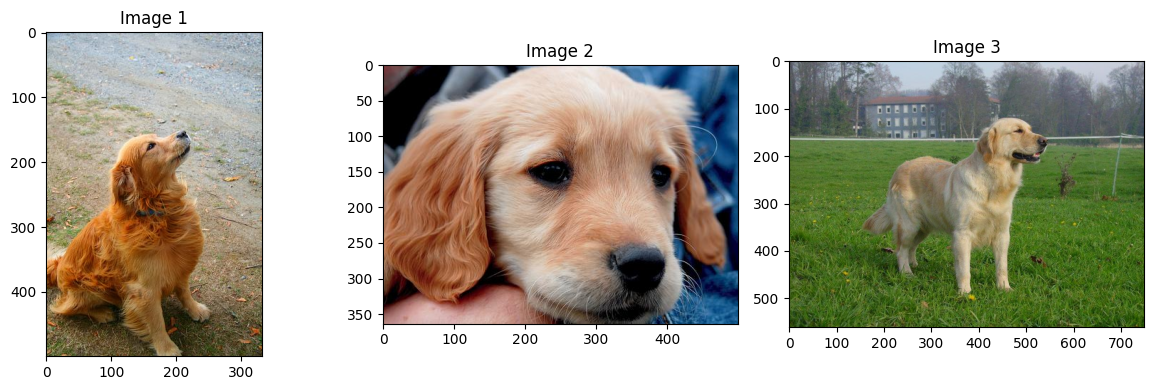

husky


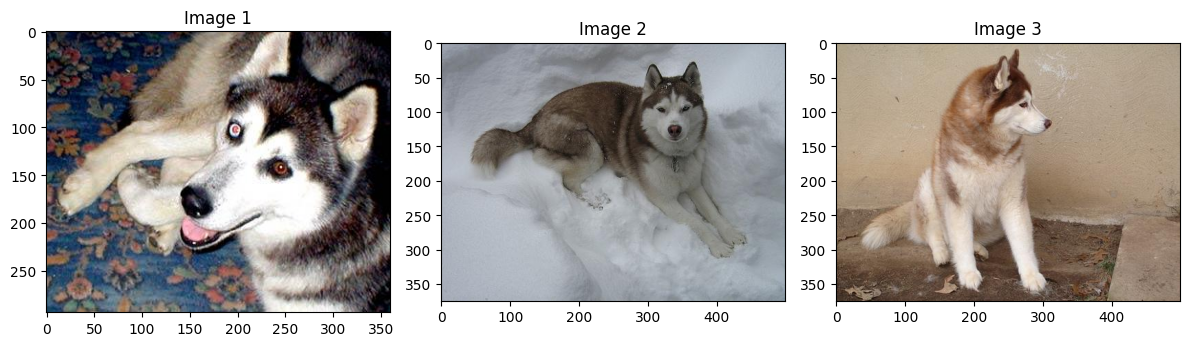

chihuahua


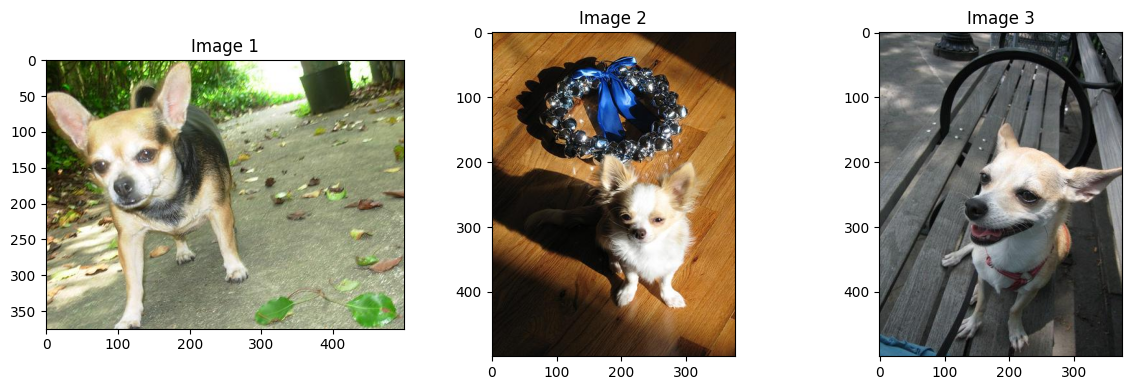

In [ ]:
from matplotlib import pyplot as plt
from matplotlib.image import imread

def list_fct(name):
    list_image_name = data.loc[data["label_name"] == name, "image_path"].tolist()
    return list_image_name

# Liste des noms de labels uniques dans votre DataFrame
list_labels = data["label_name"].unique()

# Affichage de quelques images pour chaque classe
for name in list_labels:
    print(name)
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))  # Crée une grille de 1 ligne et 3 colonnes de sous-graphiques

    # Sélectionne les trois premières images de la classe actuelle
    for i in range(3):
        filename = list_fct(name)[i]
        image = imread(filename)
        axes[i].imshow(image)
        axes[i].set_title(f'Image {i+1}')  # Ajoute un titre à chaque sous-graphique

    plt.tight_layout()
    plt.show()


# Étape 1 : Étude de faisabilité
Création du modèle pré-entraîné et extraction des features


Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

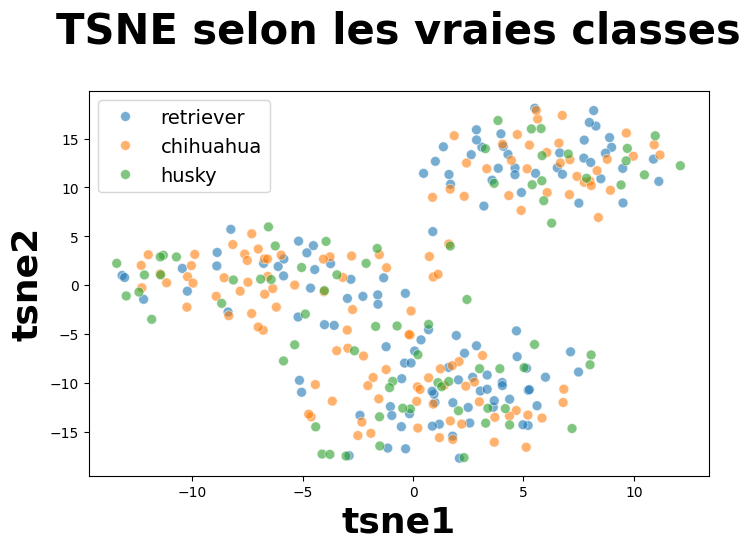

In [ ]:
## Création du modèle pré-entraîné
base_model = VGG16()
model = Model(inputs=base_model.inputs, outputs=base_model.layers[-2].output)
print(model.summary())

## Création des features des images
images_features = []
i = 0
for image_file in data["image_path"]:
    if i % 100 == 0:
        print(i)
    i += 1
    image = load_img(image_file, target_size=(224, 224))
    image = img_to_array(image)
    image = np.expand_dims(image, axis=0)
    image = preprocess_input(image)
    images_features.append(model.predict(image, verbose=0)[0])  # predict from pretrained model

images_features = np.asarray(images_features)
print(images_features.shape)

### Réduction dimension et analyse
#### Réduction de dimension PCA
from sklearn import manifold, decomposition

pca = decomposition.PCA(n_components=0.99)
feat_pca = pca.fit_transform(images_features)
print(feat_pca.shape)

#### Réduction de dimension T-SNE et affichage des images selon vraies classes
import time

temps1 = time.time()
tsne = manifold.TSNE(n_components=2, perplexity=30, n_iter=2000, init='random', random_state=6)
X_tsne = tsne.fit_transform(feat_pca)
duration1 = time.time() - temps1
print("temps de T-SNE : ", "%15.2f" % duration1, "secondes")

df_tsne = pd.DataFrame(X_tsne, columns=['tsne1', 'tsne2'])
df_tsne["class"] = data["label_name"]

plt.figure(figsize=(8, 5))
sns.scatterplot(
    x="tsne1", y="tsne2",
    hue="class",
    palette=sns.color_palette('tab10', n_colors=3), s=50, alpha=0.6,
    data=df_tsne,
    legend="brief")

plt.title('TSNE selon les vraies classes', fontsize=30, pad=35, fontweight='bold')
plt.xlabel('tsne1', fontsize=26, fontweight='bold')
plt.ylabel('tsne2', fontsize=26, fontweight='bold')
plt.legend(prop={'size': 14})
plt.show()


* L'analyse graphique montre visuellement qu'il est réalisable de séparer automatiquement les images selon leurs vraies classes
* Ceci suffit à démontrer la faisabilité de réaliser ultérieurement une classification supervisée pour déterminer automatiquement les classes des images
* Cette étape 1 est très rapide à mettre en oeuvre. Une conclusion négative sur la faisabilité aurait éviter de réaliser des traitements beaucoup plus lourd de classification supervisée
* Cette démarche en 2 étapes (1. Faisabilité, 2. Classification supervisée si étape 1 OK) s'inscrit dans une démarche agile de tout projet Data

### Création de clusters à partir du T-SNE et affichage des images selon clusters
* Attention : ici, il ne s'agit pas de faire une classification non supervisée, mais simplement, par une mesure de l'ARI, de conforter l'analyse graphique précédente qui démontre la faisabilité de réaliser ultérieurement une classification supervisée. Cette mesure de l'ARI nécessite de créer des clusters théoriques via KMeans
* Il s'agit donc de réaliser une mesure de ce que nous voyons graphiquement, donc à partir des données en sortie du t-sne
* Pour réaliser une classification non supervisée, il aurait fallu repartir des données avant t-sne
* Dans la démarche en 2 étapes, il n'est pas utile de réaliser une classification non supervisée, une classification supervisée est bien plus performante. Même le calcul de l'ARI n'est pas indispensable, nous pourrions passer directement du graphique t-sne précédent à l'étape 2 de classification supervisée
* Il n'est donc pas utile de passer du temps à optimiser l'ARI, un ordre de grandeur suffit pour conforter le 1er graphique t-sne. D'ailleurs la meilleure solution de feature engineering ne génère pas toujours le meilleur ARI. L'analyse graphique t-sne est bien plus riche d'enseignement


In [ ]:
from sklearn import cluster, metrics

cls = cluster.KMeans(n_clusters=3, n_init=100)
cls.fit(X_tsne)

KMeans(n_clusters=3, n_init=100)

<ipython-input-68-7858d4997e45>:4: UserWarning: The palette list has more values (4) than needed (3), which may not be intended.
  sns.scatterplot(


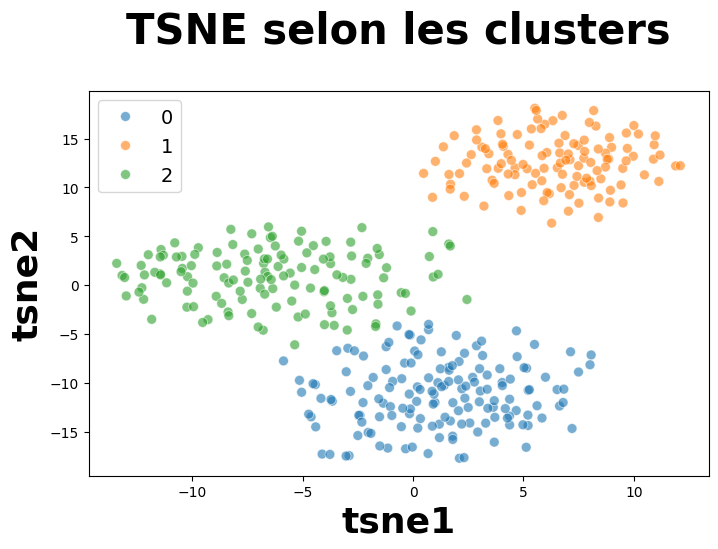

ARI :  0.9126607926995498


In [ ]:
df_tsne["cluster"] = cls.labels_

plt.figure(figsize=(8,5))
sns.scatterplot(
    x="tsne1", y="tsne2",
    hue="cluster",
    palette=sns.color_palette('tab10', n_colors=4), s=50, alpha=0.6,
    data=df_tsne,
    legend="brief")

plt.title('TSNE selon les clusters', fontsize = 30, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
plt.legend(prop={'size': 14})

plt.show()

labels = data["label"]
print("ARI : ", metrics.adjusted_rand_score(labels, cls.labels_))

- cluster 0 : husky
- cluster 1 : retriever
- cluster 2 : chihuahua



In [ ]:
# Analyse d'image "retriever" affectées au cluster 0 "husky"

list_shine_0 = [i for i in range(len(data["image_path"])) \
                if (data.iloc[i]['label_name']=='retriever') and (df_tsne.iloc[i]['cluster']==0)]
list_shine_0

[386]

tsne1       4.617979
tsne2       11.99483
class      retriever
cluster            1
Name: 17, dtype: object


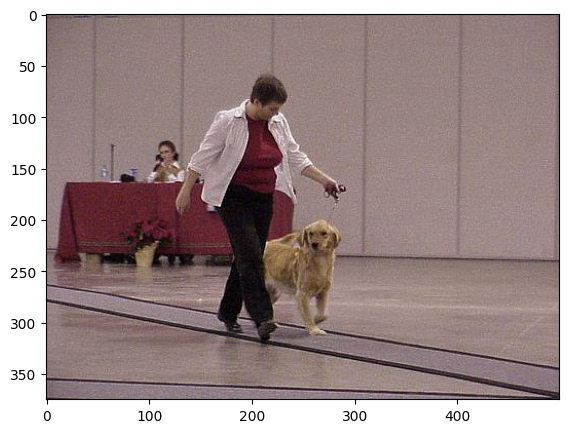

In [ ]:
# Affichage image "retriever" considérée comme "husky"
id = 17
print(df_tsne.iloc[id])
fig = plt.figure(figsize = (8, 5))
# plt.subplot(130 + 1 + i)
filename = data["image_path"][id]
image = imread(filename)
plt.imshow(image)
plt.show()


tsne1      -0.088067
tsne2       -7.97424
class      retriever
cluster            0
Name: 142, dtype: object


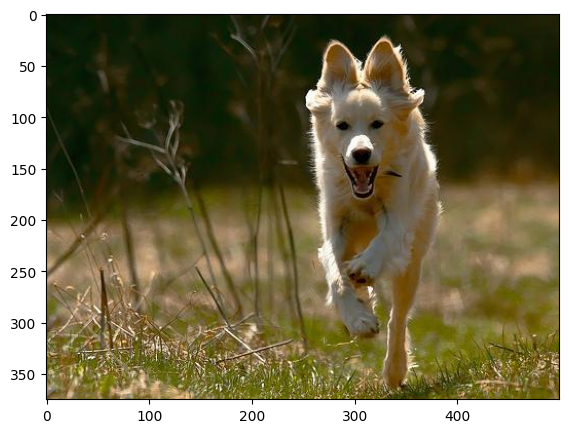

In [ ]:
# Affichage image "retriever" considérée comme "husky"
id = 142
print(df_tsne.iloc[id])
fig = plt.figure(figsize = (8, 5))
# plt.subplot(130 + 1 + i)
filename = data["image_path"][id]
image = imread(filename)
plt.imshow(image)
plt.show()


In [ ]:
# Analyse d'image "chihuahua" affectées au cluster 1 "retriever"

list_shine_1 = [i for i in range(len(data["image_path"])) \
                if (data.iloc[i]['label_name']=='chihuahua') and (df_tsne.iloc[i]['cluster']==0)]
list_shine_1

[340]

In [ ]:
# Affichage image "husky" considérée comme "chihuahua"
id = 202
print(df_tsne.iloc[id])
fig = plt.figure(figsize = (8, 5))
# plt.subplot(130 + 1 + i)
filename = data["image_path"][id]
image = imread(filename)
plt.imshow(image)
plt.show()


tsne1     -5.045608
tsne2      5.517023
class           NaN
cluster           2
Name: 202, dtype: object


KeyError: 202

<Figure size 800x500 with 0 Axes>

In [ ]:
# Analyse d'image "husky" affectées au cluster 2 "chihuahua"

list_shine_2 = [i for i in range(len(data["image_path"])) \
                if (data.iloc[i]['label_name']=='husky') and (df_tsne.iloc[i]['cluster']==2)]
list_shine_2

In [ ]:
# Affichage image "husky" considérée comme "chihuahua"
id = 318
print(df_tsne.iloc[id])
fig = plt.figure(figsize = (8, 5))
# plt.subplot(130 + 1 + i)
filename = data["image_path"][id]
image = imread(filename)
plt.imshow(image)
plt.show()


* Analyse : le modèle pré-entraîné confond certaines races avec d'autres
* L'ARI est à 0.89, l'algorithme de clustering K-MEANS a produit des clusters qui sont très proches des vrais clusters dans vos données, ce qui est excellent résultat

In [ ]:
conf_mat = metrics.confusion_matrix(labels, cls.labels_)
print(conf_mat)

In [ ]:
def conf_mat_transform(y_true,y_pred) :
    conf_mat = metrics.confusion_matrix(y_true,y_pred)

    corresp = np.argmax(conf_mat, axis=0)
    print ("Correspondance des clusters : ", corresp)
    # y_pred_transform = np.apply_along_axis(correspond_fct, 1, y_pred)
    labels = pd.Series(y_true, name="y_true").to_frame()
    labels['y_pred'] = y_pred
    labels['y_pred_transform'] = labels['y_pred'].apply(lambda x : corresp[x])

    return labels['y_pred_transform']

In [ ]:
cls_labels_transform = conf_mat_transform(labels, cls.labels_)
conf_mat = metrics.confusion_matrix(labels, cls_labels_transform)
print(conf_mat)
print()
print(metrics.classification_report(labels, cls_labels_transform))

In [ ]:
df_cm = pd.DataFrame(conf_mat, index = [label for label in list_labels],
                  columns = [i for i in "012"])
plt.figure(figsize = (6,4))
sns.heatmap(df_cm, annot=True, cmap="Blues")